In [ ]:
import numpy as np
from pyiron_feal import Project
import matplotlib.pyplot as plt
import seaborn as sns
from pyiron_feal.subroutines.configurational import _EnergyCalculator

# Summary 

Having selected our potential, we now want to run coupled MC/MD calculations and look for evidence of short range ordering (SRO) -- i.e. small clusters which locally match another topology, in this case D03 or B2.

The basic approach used here to find these clusters is to compare the final, equilibrated species against a reference B2 or D03 cell of the same size. In the case of B2 there is a two-fold degeneracy as the Al can site on either BCC sublattice. For D03 there are four different sublattice occupation possibilities. For each of these reference lattices, we search for an atom whose local environment matches the reference and then use the neighbour list to walk around the structure's topology and build up clusters.

In this case, our neighbour topology is defined by including the 1st and 2nd nearest neighbour shells (14 neighbours), and "matching" means that $N$ of your 14 nearest neighbours match the reference. The number and scope of clusters found then strongly depends on $N$, e.g. at $N=10$ we'll see that almost the entire structure is one large "cluster" because we've made our condition too weak.

Here we make no account of overlap, i.e. a particular atom is allowed to belong to a cluster representing more than one reference structure. In practice, for large $N$ this sort of overlap is extremely rare, and for more moderate $N$ does not appear to be super significant.

Regardless of which $N$ is used, it's important to consider the baseline case of clusters being observed in a randomly ordered alloy where there is *no driving force* for SRO. This forms our baseline. Unfortunately, any hope of making a numeric comparison with the experiments will be dashed since we will show that the number of D03 clusters actually *decreases* compared to the random alloy when we allow the system to anneal. 

It turns out that this is because there is a strong preference *towards* columnar (B2-like) clusters, which eats up the Al that was otherwise participating in D03 clusters. This turns out to be expected for this potential, as shown in `Zero_Kelvin_addendum.ipynb`.

In [1]:
from pyiron_feal import Project
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [2]:
pr = Project('projects/mcmd_sro')

In [7]:
# fiftytenten_nm_repeats = (87, 18, 18)
# tentwotwo_nm_repeats = (18, 4, 4)
cubic_repeats = (7, 7, 7)  # aprrox 4x4x4 nm
repeats = cubic_repeats

if len(pr.job_table()) == 0:
    ss = pr.create.structure.FeAl.bcc(c_Al=0.18, repeat=repeats)
else:
    ss = pr.load('mcmd_T523_mcT523').get_structure(0)
    assert(len(pr.create.structure.FeAl.d03(repeat=repeats)) == len(ss))
ss_symbols = ss.get_chemical_symbols()

print(f"Cell lengths = {np.diag(ss.cell.array)}; N atoms = {len(ss)}")

n_neigh = 14  # 8=1NN, 14=1+2NN
topology = ss.get_neighbors(num_neighbors=n_neigh).indices

ref_symbols = {
    f'd03_{basis}': pr.create.structure.FeAl.d03(repeat=repeats, basis=basis).get_chemical_symbols() 
    for basis in [0, 1, 2, 3]
}
ref_symbols.update({
    f'b2_{basis}': pr.create.structure.FeAl.b2(repeat=repeats, basis=basis).get_chemical_symbols() 
    for basis in [0, 1]
})


# ANG3_PER_M3 = 1E30
# count_to_density = 1E-24 * (np.prod(np.diag(ss.cell.array))**-1 * ANG3_PER_M3)  # Manuscript units 1E24/m^3

Cell lengths = [40.18 40.18 40.18]; N atoms = 5488


In [8]:
pr.mcmd_sro.define_clustering(topology, ref_symbols, threshold=11)

In [9]:
# Peek at clusters 
ss_clusters = pr.mcmd_sro.cluster(ss_symbols)
ss_clusters.stats

{'d03_0': array([[  1,  16],
        [  2,  11],
        [  3,  10],
        [  4,   1],
        [  5,   1],
        [  6,   1],
        [  7,   3],
        [  9,   2],
        [ 10,   2],
        [ 12,   2],
        [ 13,   1],
        [ 22,   1],
        [169,   1],
        [210,   1]]),
 'd03_1': array([[  1,  31],
        [  2,  15],
        [  3,   7],
        [  4,   7],
        [  5,   5],
        [  6,   3],
        [  7,   2],
        [  9,   1],
        [ 10,   1],
        [ 11,   1],
        [ 16,   1],
        [ 18,   1],
        [ 28,   1],
        [ 65,   1],
        [ 95,   1],
        [101,   1]]),
 'd03_2': array([[ 1, 22],
        [ 2,  8],
        [ 3,  7],
        [ 4,  6],
        [ 5,  2],
        [ 6,  2],
        [ 7,  1],
        [ 8,  2],
        [ 9,  1],
        [11,  1],
        [12,  2],
        [14,  1],
        [15,  2],
        [19,  1],
        [23,  1],
        [27,  1],
        [33,  1],
        [49,  1],
        [59,  1],
        [60,  1]]),
 'd03_3

# Run simulations 

At a variety of temperatures in the experimental range we run coupled Monte Carlo/Molecular Dynamics (MCMD) calculations. These are performed with a strict variance constraint so the final concentration is very similar to the nominal alloy composition, and while we keep the MD temperature fixed we will "anneal" the MC temperature from the MD temperature down to 10 K to lock in the Al configuration for topological analysis.

In [10]:
def run_jobs(pr, T, mc_temperatures):
    annealing_jobs = {}
    
    for mc_temp in mc_temperatures:
        job = pr.create.job.Lammps(f'mcmd_T{int(T)}_mcT{int(mc_temp)}', delete_existing_job=False)
        job.potential = pr.input.potentials_eam[0]

        try:
            job.structure = annealing_jobs[-1].get_structure()
            initial_temperature = T
        except:
            job.structure = ss.copy()
            initial_temperature = None

        job.calc_vcsgc(
            mu={'Fe': 0, 'Al': 0},
            target_concentration={'Fe': 1 - 0.18, 'Al': 0.18},
            temperature=T, 
            mc_step_interval=50, 
            n_print=50,
            langevin=True, 
            n_ionic_steps=1e4, #1k steps is ~4 min with the cubic structure
            kappa=1e4,
            temperature_mc=mc_temp,
            initial_temperature=initial_temperature
        )
        job.run()
        annealing_jobs[f'mcT{int(mc_temp)}'] = job
    
    return annealing_jobs

In [11]:
temperatures = np.linspace(523, 873, 5)
temperature_jobs, temperature_mc_Ts = {}, {}

for T in temperatures:
    mc_temperatures = np.linspace(T, 10, 5)
    temperature_mc_Ts[f'T{int(T)}'] = mc_temperatures
    jobs = run_jobs(pr, T, mc_temperatures)
    temperature_jobs[f'T{int(T)}'] = jobs

2021-08-25 15:17:39,485 - pyiron_log - WARNING - The job mcmd_T523_mcT523 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
/Users/huber/Liam/pyiron/pyiron_repos/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
2021-08-25 15:17:40,347 - pyiron_log - WARNING - The job mcmd_T523_mcT394 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-08-25 15:17:41,871 - pyiron_log - WARNING - The job mcmd_T523_mcT266 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-08-25 15:17:42,882 - pyiron_log - WARNING - The job mcmd_T523_mcT138 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-08-25 15:17:43,747 - pyiron_log - WARNING - The job mcmd_T523_mcT10 is bein

# Cluster construction

Next we'll use breadth-first-search to build up clusters for each of the references and then add up the results for referecnes of the same phase. This is done for a variety of threshold $N$ values, but $N=11$ turns out to give a nice balance between finding many and large clusters without simply decaying into one massive too-accepting "cluster".

In [12]:
def analyze_clusters(pr, T, mc_temperatures, threshold=None):
    annealing_clusters = {}
    
    for mc_temp in mc_temperatures:
        job_name = f'mcmd_T{int(T)}_mcT{int(mc_temp)}'
        job_hdf = pr.inspect(job_name)
        if job_hdf is None:
            raise RuntimeError(f'HDF for job {job_name} was not found.')
        

        indices = job_hdf['output/generic/indices'][-1]
        mcmd_symbols = np.array(len(indices)*['Fe'])
        mcmd_symbols[indices == 1] = 'Al'
        annealing_clusters[f'mcT{int(mc_temp)}'] = pr.mcmd_sro.cluster(mcmd_symbols, threshold=threshold)
    return annealing_clusters

# TODO: Get rid of ref_symbols and neigh being global vars

In [13]:
thresholds = [10, 11, 12, 13, 14]
thresholded_clusters = {}
for thresh in thresholds:
    print(f"THRESHOLD = {thresh}")
    ref_clusters = pr.mcmd_sro.cluster(ss_symbols, threshold=thresh)
    temperature_clusters = {}
    for T in temperatures:
        mc_temperatures = temperature_mc_Ts[f'T{int(T)}']
        clusters = analyze_clusters(pr, T, mc_temperatures, threshold=thresh)
        temperature_clusters[f'T{int(T)}'] = clusters
    thresholded_clusters[thresh] = (ref_clusters, temperature_clusters)

THRESHOLD = 10
THRESHOLD = 11
THRESHOLD = 12
THRESHOLD = 13
THRESHOLD = 14


Also note that we're ignoring here clusters of size 1:

In [ ]:
thresholded_clusters[11][0].d03.singlets

# Analysis

First, let's simply visualize the annealed structures and the references. We can easily see that after MCMD the system prefers to build 1D chains of Al (at 2NN positions), which are basically needle-like B2 precipitates.

In [14]:
def plot_final_step_on_lattice(job, frame=-1, repeats=repeats):
    ref_struct = pr.create.structure.FeAl.bcc(repeat=repeats)
    struct = job.get_structure(frame=frame)
    symbols = struct.get_chemical_symbols()
    ref_struct[symbols == 'Fe'] = 'Fe'
    ref_struct[symbols == 'Al'] = 'Al'
    return ref_struct.plot3d()

In [15]:
plot_final_step_on_lattice(temperature_jobs['T523']['mcT10'])

NGLWidget()

In [16]:
plot_final_step_on_lattice(temperature_jobs['T873']['mcT10'])

NGLWidget()

In [17]:
pr.create.structure.FeAl.d03(repeat=repeats).plot3d()

NGLWidget()

In [18]:
pr.create.structure.FeAl.b2(repeat=repeats).plot3d()

NGLWidget()

We can also do numeric analysis on the located clusters. Many more D03 clusters are identified than B2, but this is sensible since we are much closer to a nominal D03 concentration than B2 -- the pure-Fe environments really load up the small cluster sizes.

Since the clustering definition is not absolute (i.e. we use a threshold $N<14$ and need to make choices about how big the local environment is and how far the neighbour topology extends), it is critical to compare the clusters identified to how many would be identified in a similar system with completely random ordering.

In [19]:
def my_hist(cluster, phase, binsize=10, title=None, clip=None):
    sizes = getattr(cluster, phase)
    biggest = np.amax(sizes)
    sizes = np.clip(sizes, 0, clip) if clip is not None else sizes
    plt.hist(sizes, bins=np.arange(np.amax(sizes) + binsize, step=binsize))
    plt.yscale('log')
    plt.xlabel('Cluster size (atoms)')
    plt.ylabel('Counts')
    plt.title(
        f'{title}, {phase}\n' + 
        f'biggest={biggest}, clusts>{binsize}={np.sum(sizes > binsize)}\n' + 
        f'tot={np.sum(sizes)}'
    )

THRESHOLD = 11
PHASE d03


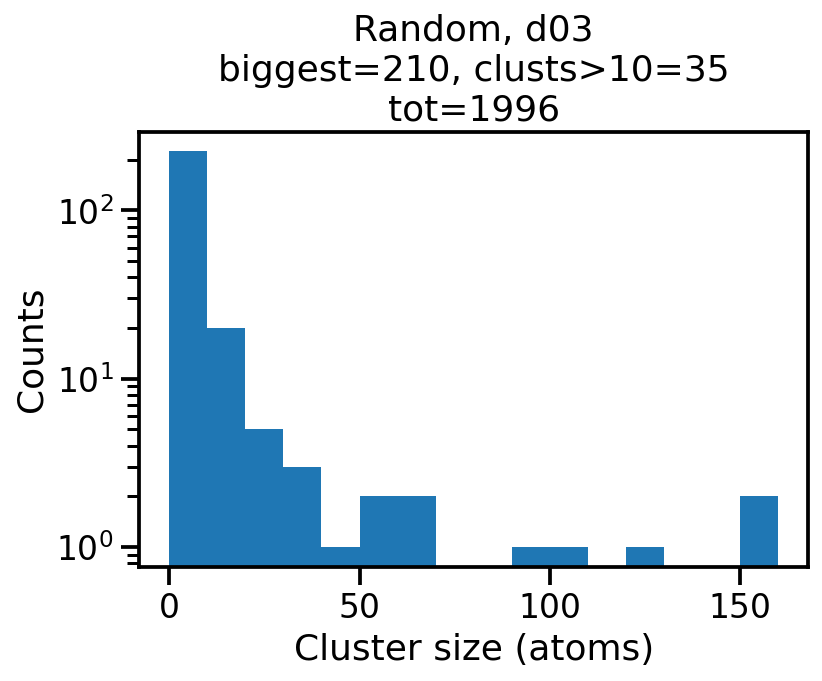

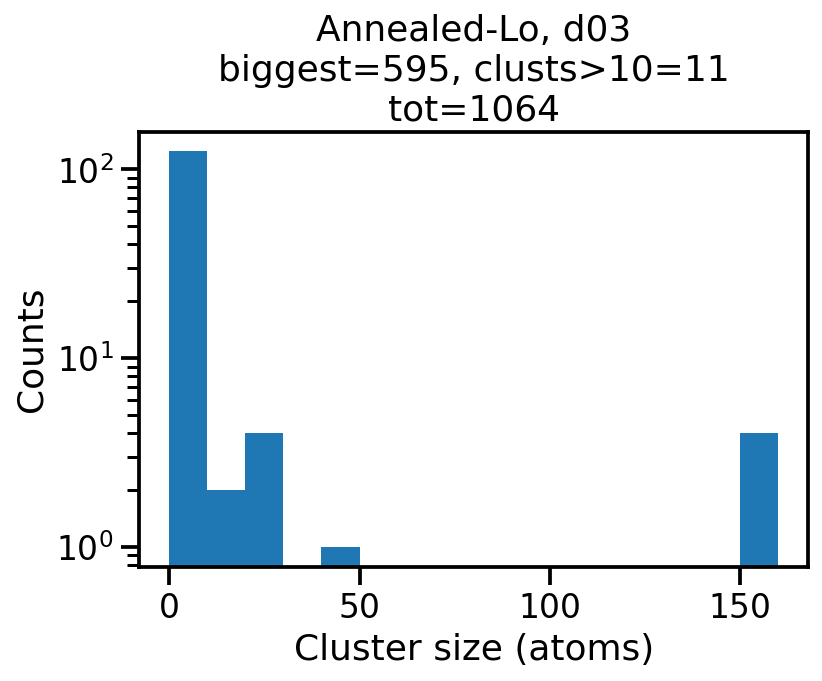

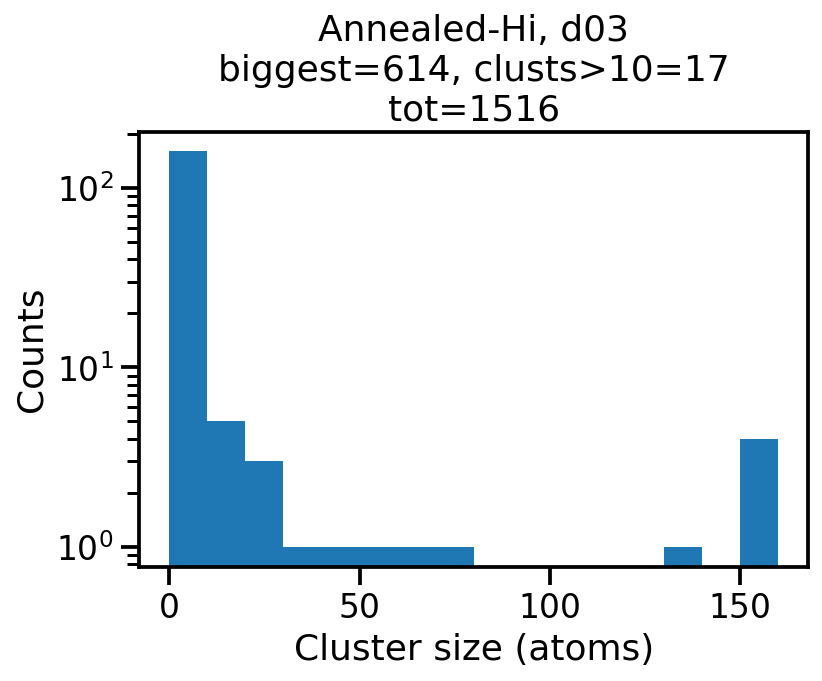

PHASE b2


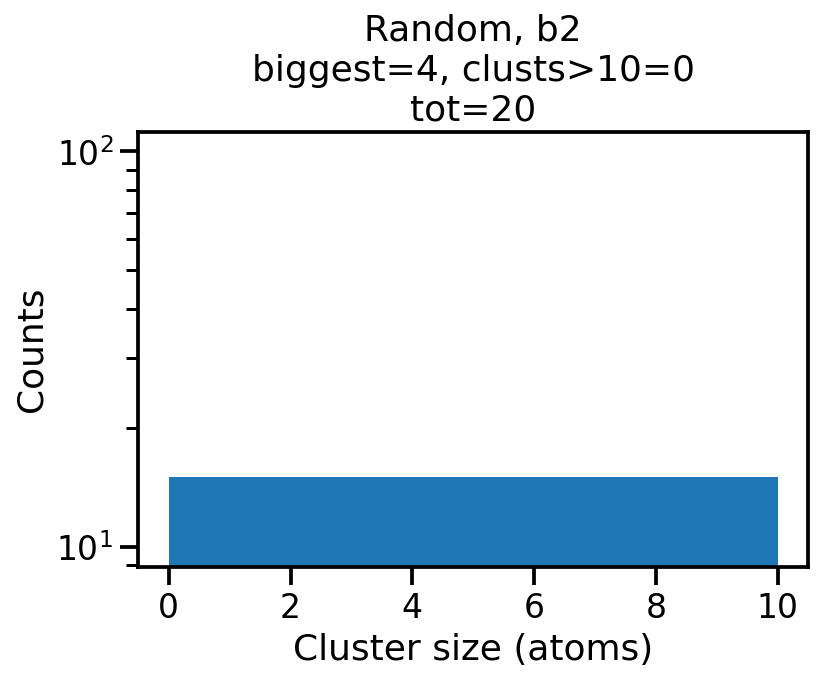

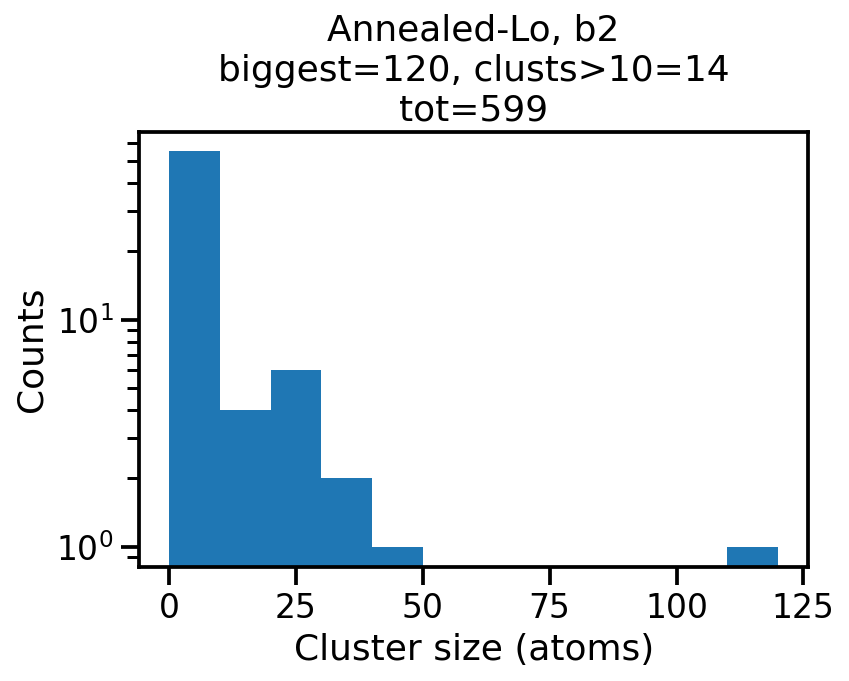

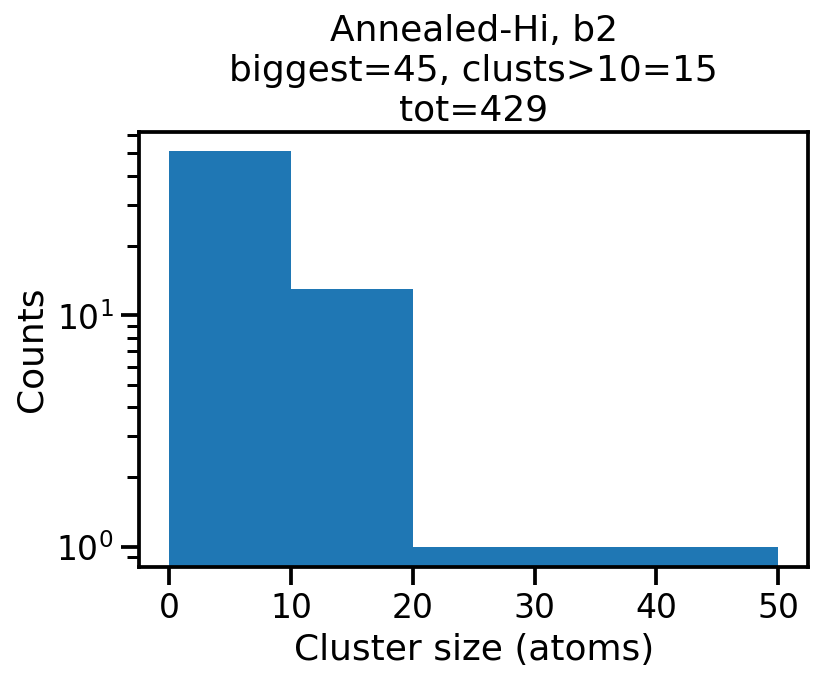

In [24]:
binsize = 10
clip = 160
for k, v in thresholded_clusters.items():
    if k not in [11]:
        continue
    print(f"THRESHOLD = {k}")
    ref_cluster, temperature_clusters = v
    for phase in ['d03', 'b2']:
        print(f"PHASE {phase}")
        my_hist(ref_cluster, phase, binsize=binsize, title='Random', clip=clip)
        plt.show()
        my_hist(temperature_clusters['T523']['mcT523'], phase, binsize=binsize, title='Annealed-Lo', clip=clip)
        plt.show()
        my_hist(temperature_clusters['T873']['mcT873'], phase, binsize=binsize, title='Annealed-Hi', clip=clip)
        plt.show()

We can also visualize the clusters, e.g. the snipped below lets us easily peak at the biggest cluster matching a particular reference.

In [29]:
Tstring, mcTstring = 'T523', 'mcT10'
a_job = temperature_jobs[Tstring][mcTstring]
a_cluster = thresholded_clusters[11][1][Tstring][mcTstring]['b2_0']
a_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]

a_struct = a_job.get_structure().copy()
a_struct[a_cluster].repeat(2).plot3d()

NGLWidget()

# Conclusion

The clustering algorithm is not perfect, but by comparing to the random structure it seems relatively robust -- it correctly identifies that we get a bunch of large B2-like precipitates, which are obvious from visual inspection. However, the imperfections don't really matter since experimentally D03 precipitates are observed and we're simply not seeing these here. We can intuit from this that somehow the phase diagram prefers these needle-like precipitates over D03, which is more or less confirmed in the Zero Kelvin addendum notebook. In fact, after making that notebook and revisiting the cluster visualization here, it's even possible to see the plate-like Al planes forming.

Ultimately, it was a neat little investigation, but the empirical potential simply isn't going to produce anything remotely like what is seen in experiment. Since the other potentials showed issues even earlier in the investigation I will just give up here -- including not polishing this up too much and incorporating it with the `pyiron_feal` codebase any further.